# Rule Extraction and XAI metrics

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from lib.xai_auxiliary_rule_extraction import generateRuleHypercubes
from lib.xai_rule_metrics import (checkFidelity, 
                                  checkStability,
                                  checkDiversity)
from lib.xai_tools import plot_2D, loadDatasets

### 1. Load Data & Get Anomalies

In [4]:
# Load data
df_input, _, _ = loadDatasets(f_name = "seismic-bumps")
numerical_cols = ["gdenergy", "gdpuls"]  # 2D
categorical_cols = []
df_input = (df_input[numerical_cols + categorical_cols + ['target_class']]
            .drop_duplicates(subset = numerical_cols + categorical_cols)
            )
df_input.head()

,gdenergy,gdpuls,target_class
0,-72,-72,1
1,-70,-79,1
2,-81,-78,1
3,-23,40,1
4,-63,-52,1


In [5]:
# Train model & Get predictions
df_train = df_input.copy().drop(columns=['target_class'])
clf = IsolationForest()
y_pred_train = clf.fit_predict(df_train)
dist = clf.decision_function(df_train)
df_anomalies = df_input.copy()
df_anomalies["predictions"] = y_pred_train
df_anomalies["dist"] = dist
df_anomalies["score"] = clf.decision_function(df_train)
df_anomalies.head()

,gdenergy,gdpuls,target_class,predictions,dist,score
0,-72,-72,1,1,0.006566,0.006566
1,-70,-79,1,-1,-0.009646,-0.009646
2,-81,-78,1,-1,-0.031926,-0.031926
3,-23,40,1,1,0.025130,0.025130
4,-63,-52,1,1,0.067058,0.067058


In [6]:
# Paths
path_folder = "pruebasIF"
file_template = "DT_IF"

method = "DecisionTree"
# list_methods = ["DecisionTree", "RuleFit", "FRL", "SkopeRules", "DecisionRuleList", "brlg", "logrr"]

### 2. Get Rules as Hypercubes

In [7]:
## 1. Get Rules (Hypercube)
# Define hyperparams for the XAI model
model_params = {}
# Generate rules hypercubes
df_rules_inliers, df_rules_outliers = generateRuleHypercubes(
    df_anomalies = df_anomalies,
    numerical_cols = numerical_cols,
    categorical_cols = categorical_cols,
    method = method,
    simplify_rules = True,
    model_params = model_params,
)
df_rules_inliers.head()

Depth tree:  14
Nodes tree:  93
leaf nodes not anomalies:  51
tree rules not anomalies:  24
tree rules anomalies:  16
Turning rules to hypercubes...
Prunning the rules obtained...
Iter 0/19
Iter 1/19
Iter 2/19
Iter 3/19
Iter 4/19
Iter 5/19
Iter 6/19
Iter 7/19
Iter 8/19
Iter 9/19
Iter 10/19
Iter 11/19
Iter 12/19
Iter 13/19
Iter 14/19
Iter 15/19
Iter 16/19
Iter 17/19
Iter 18/19
No more improvements... finishing up
Turning rules to hypercubes...
Prunning the rules obtained...
Iter 0/26
Iter 1/26
Iter 2/26
Iter 3/26
Iter 4/26
Iter 5/26
Iter 6/26
Iter 7/26
Iter 8/26
Iter 9/26
Iter 10/26
Iter 11/26
Iter 12/26
Iter 13/26
Iter 14/26
Iter 15/26
Iter 16/26
Iter 17/26
Iter 18/26
Iter 19/26
Iter 20/26
Iter 21/26
Iter 22/26
Iter 23/26
Iter 24/26
Iter 25/26
No more improvements... finishing up


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction
index,,,,,,
0,-16.5,-77.0,-67.5,-72.5,9,1
10,109.5,-inf,92.0,49.5,6,1
2,19.0,-78.5,-44.5,-67.5,10,1
4,91.5,91.5,-3.5,-44.5,13,1
5,-48.5,-76.5,80.5,-44.5,12,1


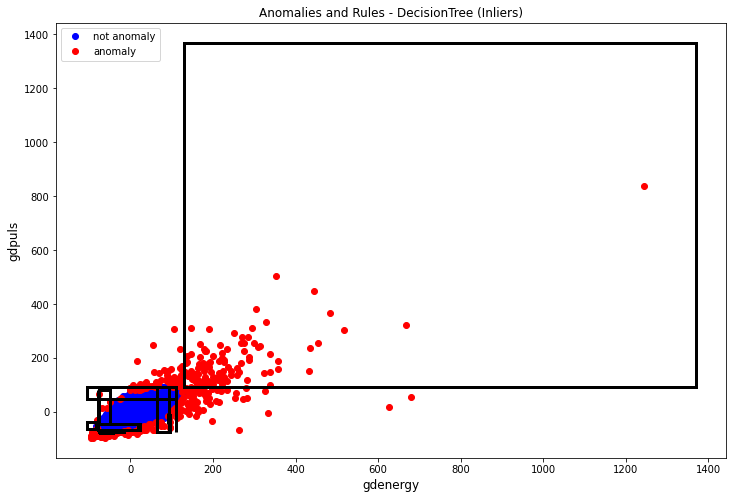

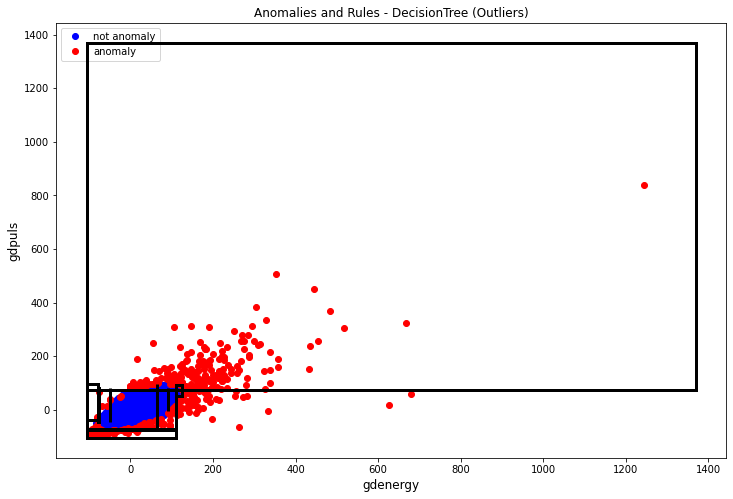

In [8]:
## 2. Plot Results [Only for 2D]
max_replace = df_input.max().max() + np.abs(df_input.max().max()) * 0.1
min_replace = df_input.min().min() - np.abs(df_input.min().min()) * 0.1
df_inliers_plot = (
    df_rules_inliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
) 
df_outliers_plot = (
    df_rules_outliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
)

plot_2D(df_inliers_plot, df_anomalies, title = method + ' (Inliers)')
plot_2D(df_outliers_plot, df_anomalies, title = method + ' (Outliers)')

### 3. XAI Metrics

In [9]:
# Precision (unsupervised model predictions vs ground truth)
target_names = ['outliers', 'inliers']
y_true = df_anomalies['target_class']
y_pred = df_anomalies['predictions']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    outliers       0.20      0.35      0.25       229
     inliers       0.92      0.85      0.88      2143

    accuracy                           0.80      2372
   macro avg       0.56      0.60      0.57      2372
weighted avg       0.85      0.80      0.82      2372



In [10]:
# Comprehensibility
n_rules_inliers = len(df_rules_inliers)
n_rules_outliers = len(df_rules_outliers)
mean_rule_size_inliers = df_rules_inliers['size_rules'].mean()
mean_rule_size_outliers = df_rules_outliers['size_rules'].mean()

In [ ]:
# Fidelity/Representativeness/Focus on Abnormal
df_rules_inliers, df_rules_outliers, df_anomalies = checkFidelity(
    df_anomalies, df_rules_inliers, df_rules_outliers, numerical_cols, 
    categorical_cols
    )
df_rules_inliers.head()

Getting rule predictions...
Iter 0/2372
Iter 500/2372
Iter 1000/2372
Iter 1500/2372
Iter 2500/2372

Getting rule coverage...
Iter 0/2372
Iter 500/2372


In [ ]:
# Stability
df_rules_inliers = checkStability(df_anomalies, df_rules_inliers, clf,
                                  numerical_cols, categorical_cols,
                                  using_inliers = True)
df_rules_outliers = checkStability(df_anomalies, df_rules_outliers, clf,
                                   numerical_cols, categorical_cols,
                                   using_inliers = False)
df_rules_inliers.head()

In [ ]:
# Diversity
df_rules_inliers, _ = checkDiversity(df_rules_inliers, 
                                     numerical_cols, 
                                     categorical_cols)
df_rules_outliers, _ = checkDiversity(df_rules_outliers, 
                                      numerical_cols, 
                                      categorical_cols)
df_rules_inliers.head()